In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import interp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.dummy import DummyClassifier

# Load data

In [2]:
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
target_labels = [val for key, val in emotion_labels.items()]
targets = [key for key, val in emotion_labels.items()]

In [3]:
def load_data(df, data_type):
    """Load data from DataFrame and return data to list 
    """
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        if data_type == 1:
            field = row.pca
        elif data_type == 2:
            field = row.histogram
        elif data_type == 3:
            field = row.hog
        elif data_type == 4:
            field = row.lda
        else:
            field = row.pixels
        image = np.fromstring(field, sep=' ')
        image_data.append(image)
        if data_type == 0:
            scale = image / 255.0
            image_scaled.append(scale)
        
    return image_data, image_scaled

# Grid Search with PCA data

Find out the good tuning for hyper parameter with PCA data because it takes long time to get result with original data.

10k train data and 2500 test data are used for this.

In [4]:
df = pd.read_csv('data/pca/fer_pca.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.4589713258466278 0.962093546388383 -0.55788...
1,train,3,0.49198604184990685 -1.0021801630235339 0.2740...
2,train,3,-0.9419501076570959 1.4385249489843621 0.29373...
3,train,3,-1.2800578618783192 0.23932335345423272 0.4704...
4,train,3,0.10681625087574084 -0.7089926999517396 0.3826...


In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, train_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 103)
(31432,)
(7896, 103)
(7896,)


In [8]:
X_train = X_train[0:10000]
y_train = y_train[0:10000]
X_test = X_test[0:2500]
y_test = y_test[0:2500]

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10000, 103)
(10000,)
(2500, 103)
(2500,)


## Find out which kernel is best

In [10]:
param_gamma = ['auto', 'scale']
param_grid = [{'kernel': ['linear']},
              {'gamma': param_gamma, 
               'kernel': ['rbf']},
              {'gamma': param_gamma,
               'kernel': ['poly']}]

svm = SVC(random_state=1, decision_function_shape='ovo')

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [11]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

0.7896000000000001
{'gamma': 'auto', 'kernel': 'rbf'}
Test accuracy: 0.789


## Find out which C is best

In [12]:
param_c =  [1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 10.0, 20.0, 30.0, 50.0]
param_grid = [{'C': param_c,
               'gamma': ['auto'],
               'kernel': ['rbf']}]

svm = SVC(random_state=1, decision_function_shape='ovo')

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [13]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

0.7994000000000001
{'C': 3.0, 'gamma': 'auto', 'kernel': 'rbf'}
Test accuracy: 0.794


Following comparison use RBF kernel, auto gamma, and C as 3. 

# SVM with original dataset

In [4]:
df = pd.read_csv('data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scale = load_data(df_train, 0)
train_target = list(df_train.emotion)
test_data, test_scale = load_data(df_test, 0)
test_target = list(df_test.emotion)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 2304)
(31432,)
(7896, 2304)
(7896,)


In [ ]:
svm = SVC(C=3, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
print('Test Accuracy: %.3f' % svm.score(X_test, y_test))

In [ ]:
orig_predictions = [y_pred]
orig_actuals = [y_test]

In [ ]:
# Scaled data
X_train = np.array(train_scale)
y_train = np.array(train_target)
X_test = np.array(test_scale)
y_test = np.array(test_target)

In [ ]:
svm = SVC(C=3, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
print('Test Accuracy: %.3f' % svm.score(X_test, y_test))

In [ ]:
orig_predictions.append(y_pred)
orig_actuals.append(y_test)

## Evaluation

### Confusion matrix

In [8]:
def show_confusion_matrix(confmat):
    """Display confusion matrix with percent values 
    """
    confmat = confmat/np.sum(confmat) * 100
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            percent = "{:.2f}".format(confmat[i, j])
            ax.text(x=j, y=i, s=percent+'%', va='center', ha='center')


    ax.set_xticklabels([''] + target_labels)
    ax.set_yticklabels([''] + target_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [ ]:
i = 0
confmat = confusion_matrix(y_true=orig_actuals[i], y_pred=orig_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [ ]:
i = 0
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

In [ ]:
i = 1
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

# SVM with PCA

In [5]:
def processSVM(csv, data_type):
    """Process SVM for each csv data
    """
    print(csv)
    df = pd.read_csv(csv)
    df.head()
    
    df_train = df[df['usage']=='train']
    df_test = df[df['usage']=='test']
    train_data, train_scaled = load_data(df_train, data_type)
    train_target = list(df_train.emotion)
    test_data, test_scaled = load_data(df_test, data_type)
    test_target = list(df_test.emotion)
    
    X_train = np.array(train_data)
    y_train = np.array(train_target)
    X_test = np.array(test_data)
    y_test = np.array(test_target)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    svm = SVC(C=5, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
    print('Test Accuracy: %.3f' % svm.score(X_test, y_test))
    
    return y_pred, y_test

In [ ]:
csv_list = ['data/pca/fer_pca.csv', 'data/pca/fer_pca_inverse.csv', 'data/pca/fer_pca_norm.csv', 
            'data/pca/fer_pca_std.csv', 'data/pca/fer_pca_scaled.csv']

In [ ]:
pca_predictions = []
pca_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 1)
    pca_predictions.append(pred)
    pca_actuals.append(act)

In [ ]:
csv_list = ['data/pca/fer_pca_scaled.csv']
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 1)
    pca_predictions.append(pred)
    pca_actuals.append(act)

## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


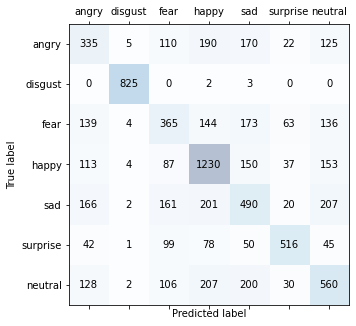

In [89]:
# Show only the best one 
i = 4
confmat = confusion_matrix(y_true=pca_actuals[i], y_pred=pca_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance matrics & Classification reports

In [9]:
def showPerformance(predictions, actuals):
    """Display performance of each result
    """
    for i in range(len(csv_list)):
        print(csv_list[i])
        print('Precision: %.3f' % precision_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Recall: %.3f' % recall_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('F1: %.3f' % f1_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Accuracy: %.3f' % accuracy_score(y_true=actuals[i], y_pred=predictions[i]))
        print('Classification reports')
        print(classification_report(actuals[i], predictions[i], target_names=list(target_labels)))

In [94]:
showPerformance(pca_predictions, pca_actuals)

data/pca/fer_pca.csv
Precision: 0.561
Recall: 0.548
F1: 0.553
Accuracy: 0.543
Classification reports
              precision    recall  f1-score   support

       angry       0.36      0.35      0.35       957
     disgust       0.98      0.99      0.99       830
        fear       0.39      0.35      0.37      1024
       happy       0.59      0.68      0.63      1774
         sad       0.39      0.39      0.39      1247
    surprise       0.77      0.62      0.68       831
     neutral       0.46      0.46      0.46      1233

    accuracy                           0.54      7896
   macro avg       0.56      0.55      0.55      7896
weighted avg       0.54      0.54      0.54      7896

data/pca/fer_pca_inverse.csv
Precision: 0.032
Recall: 0.143
F1: 0.052
Accuracy: 0.225
Classification reports
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       957
     disgust       0.00      0.00      0.00       830
        fear       0.00      0

C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_clas

# SVM with FisherFace

In [7]:
csv_list = ['data/lda/fer_lda.csv', 'data/lda/fer_lda_norm.csv', 'data/lda/fer_lda_std.csv', 'data/lda/fer_lda_scaled.csv']

In [9]:
lda_predictions = []
lda_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 4)
    lda_predictions.append(pred)
    lda_actuals.append(act)

data/lda/fer_lda.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.397
data/lda/fer_lda_norm.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.385
data/lda/fer_lda_std.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.397
data/lda/fer_lda_scaled.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.397


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_13256\1328068664.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_13256\1328068664.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


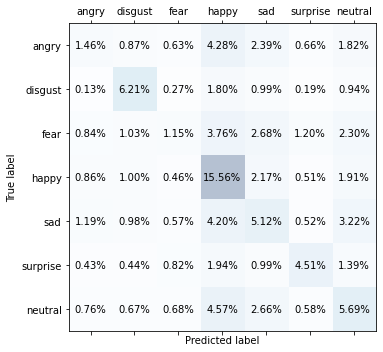

In [11]:
# Show only the best one 
i = 0
confmat = confusion_matrix(y_true=lda_actuals[i], y_pred=lda_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [12]:
showPerformance(lda_predictions, lda_actuals)

data/lda/fer_lda.csv
Precision: 0.382
Recall: 0.373
F1: 0.363
Accuracy: 0.397
Classification reports
              precision    recall  f1-score   support

       angry       0.26      0.12      0.16       957
     disgust       0.55      0.59      0.57       830
        fear       0.25      0.09      0.13      1024
       happy       0.43      0.69      0.53      1774
         sad       0.30      0.32      0.31      1247
    surprise       0.55      0.43      0.48       831
     neutral       0.33      0.36      0.35      1233

    accuracy                           0.40      7896
   macro avg       0.38      0.37      0.36      7896
weighted avg       0.38      0.40      0.37      7896

data/lda/fer_lda_norm.csv
Precision: 0.368
Recall: 0.361
F1: 0.351
Accuracy: 0.385
Classification reports
              precision    recall  f1-score   support

       angry       0.27      0.16      0.20       957
     disgust       0.53      0.58      0.56       830
        fear       0.22      0.09

# SVM with SIFT

In [97]:
csv_list = ['data/sift/sift_bof_100.csv', 'data/sift/sift_bof_500.csv', 'data/sift/sift_bof_1000.csv', 
            'data/sift/sift_pca_bof_100.csv', 'data/sift/sift_pca_bof_500.csv', 'data/sift/sift_pca_bof_1000.csv']

In [22]:
sift_predictions = []
sift_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    sift_predictions.append(pred)
    sift_actuals.append(act)

data/sift/sift_bof_100.csv
(31427, 99)
(31427,)
(7895, 99)
(7895,)
Test Accuracy: 0.187
data/sift/sift_bof_500.csv
(31427, 499)
(31427,)
(7895, 499)
(7895,)
Test Accuracy: 0.190
data/sift/sift_bof_1000.csv
(31427, 999)
(31427,)
(7895, 999)
(7895,)
Test Accuracy: 0.185
data/sift/sift_pca_bof_100.csv
(31425, 99)
(31425,)
(7894, 99)
(7894,)
Test Accuracy: 0.202
data/sift/sift_pca_bof_500.csv
(31425, 499)
(31425,)
(7894, 499)
(7894,)
Test Accuracy: 0.201
data/sift/sift_pca_bof_1000.csv
(31425, 999)
(31425,)
(7894, 999)
(7894,)
Test Accuracy: 0.210


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


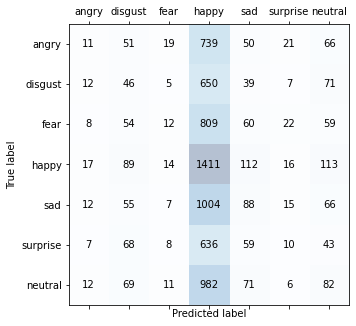

In [96]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=sift_actuals[i], y_pred=sift_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [98]:
showPerformance(sift_predictions, sift_actuals)

data/sift/sift_bof_100.csv
Precision: 0.133
Recall: 0.141
F1: 0.118
Accuracy: 0.187
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.08      0.10       957
     disgust       0.05      0.00      0.01       830
        fear       0.11      0.04      0.06      1024
       happy       0.22      0.56      0.32      1773
         sad       0.16      0.15      0.15      1247
    surprise       0.08      0.03      0.05       831
     neutral       0.15      0.13      0.14      1233

    accuracy                           0.19      7895
   macro avg       0.13      0.14      0.12      7895
weighted avg       0.15      0.19      0.14      7895

data/sift/sift_bof_500.csv
Precision: 0.161
Recall: 0.153
F1: 0.140
Accuracy: 0.190
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.07      0.09       957
     disgust       0.15      0.12      0.13       830
        fear       0.14   

# SVM with KAZE

In [26]:
csv_list = ['data/kaze/kaze_bof_100.csv', 'data/kaze/kaze_bof_500.csv', 'data/kaze/kaze_bof_1000.csv', 
            'data/kaze/kaze_pca_bof_100.csv', 'data/kaze/kaze_pca_bof_500.csv', 'data/kaze/kaze_pca_bof_1000.csv']

In [27]:
kaze_predictions = []
kaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    kaze_predictions.append(pred)
    kaze_actuals.append(act)

data/kaze/kaze_bof_100.csv
(31284, 99)
(31284,)
(7856, 99)
(7856,)
Test Accuracy: 0.205
data/kaze/kaze_bof_500.csv
(31284, 499)
(31284,)
(7856, 499)
(7856,)
Test Accuracy: 0.208
data/kaze/kaze_bof_1000.csv
(31284, 999)
(31284,)
(7856, 999)
(7856,)
Test Accuracy: 0.216
data/kaze/kaze_pca_bof_100.csv
(31275, 99)
(31275,)
(7853, 99)
(7853,)
Test Accuracy: 0.212
data/kaze/kaze_pca_bof_500.csv
(31275, 499)
(31275,)
(7853, 499)
(7853,)
Test Accuracy: 0.208
data/kaze/kaze_pca_bof_1000.csv
(31275, 999)
(31275,)
(7853, 999)
(7853,)
Test Accuracy: 0.217


## Evaluation

### Confusion matrix

In [100]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=kaze_actuals[i], y_pred=kaze_predictions[i], labels=targets)
show_confusion_matrix(confmat)

array([[   0,    3,  946,    1,    0,    7],
       [   1,    2, 1012,    4,    0,    5],
       [   2,    2, 1742,    1,    0,   26],
       [   1,    3, 1230,    0,    0,   13],
       [   0,    1,  820,    2,    0,    8],
       [   0,    3, 1194,    1,    0,   35]])

### Performance metrics & Classification reports

In [102]:
showPerformance(kaze_predictions, kaze_actuals)

Precision: 0.128
Recall: 0.169
F1: 0.076
Accuracy: 0.252


/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM with ORB

In [28]:
csv_list = ['data/orb/orb_bof_100.csv', 'data/orb/orb_bof_500.csv', 'data/orb/orb_bof_1000.csv', 
            'data/orb/orb_pca_bof_100.csv', 'data/orb/orb_pca_bof_500.csv', 'data/orb/orb_pca_bof_1000.csv']

In [29]:
orb_predictions = []
orb_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    orb_predictions.append(pred)
    orb_actuals.append(act)

data/orb/orb_bof_100.csv
(31430, 99)
(31430,)
(7896, 99)
(7896,)
Test Accuracy: 0.169
data/orb/orb_bof_500.csv
(31430, 499)
(31430,)
(7896, 499)
(7896,)
Test Accuracy: 0.213
data/orb/orb_bof_1000.csv
(31430, 999)
(31430,)
(7896, 999)
(7896,)
Test Accuracy: 0.212
data/orb/orb_pca_bof_100.csv
(31400, 99)
(31400,)
(7890, 99)
(7890,)
Test Accuracy: 0.193
data/orb/orb_pca_bof_500.csv
(31400, 499)
(31400,)
(7890, 499)
(7890,)
Test Accuracy: 0.215
data/orb/orb_pca_bof_1000.csv
(31400, 999)
(31400,)
(7890, 999)
(7890,)
Test Accuracy: 0.213


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


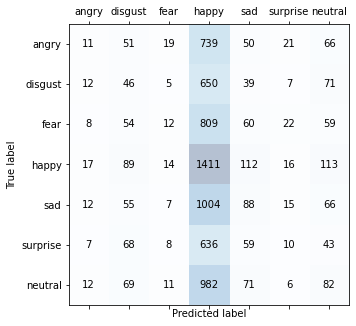

In [96]:
# Show only the best one 
i = 4
confmat = confusion_matrix(y_true=orb_actuals[i], y_pred=orb_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [98]:
showPerformance(orb_predictions, orb_actuals)

data/sift/sift_bof_100.csv
Precision: 0.133
Recall: 0.141
F1: 0.118
Accuracy: 0.187
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.08      0.10       957
     disgust       0.05      0.00      0.01       830
        fear       0.11      0.04      0.06      1024
       happy       0.22      0.56      0.32      1773
         sad       0.16      0.15      0.15      1247
    surprise       0.08      0.03      0.05       831
     neutral       0.15      0.13      0.14      1233

    accuracy                           0.19      7895
   macro avg       0.13      0.14      0.12      7895
weighted avg       0.15      0.19      0.14      7895

data/sift/sift_bof_500.csv
Precision: 0.161
Recall: 0.153
F1: 0.140
Accuracy: 0.190
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.07      0.09       957
     disgust       0.15      0.12      0.13       830
        fear       0.14   

# SVM with BRISK

In [30]:
csv_list = ['data/brisk/brisk_bof_100.csv', 'data/brisk/brisk_bof_500.csv', 'data/brisk/brisk_bof_1000.csv', 
            'data/brisk/brisk_pca_bof_100.csv', 'data/brisk/brisk_pca_bof_500.csv', 'data/brisk/brisk_pca_bof_1000.csv']

In [31]:
brisk_predictions = []
brisk_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    brisk_predictions.append(pred)
    brisk_actuals.append(act)

data/brisk/brisk_bof_100.csv
(30833, 99)
(30833,)
(7731, 99)
(7731,)
Test Accuracy: 0.213
data/brisk/brisk_bof_500.csv
(30833, 499)
(30833,)
(7731, 499)
(7731,)
Test Accuracy: 0.196
data/brisk/brisk_bof_1000.csv
(30833, 999)
(30833,)
(7731, 999)
(7731,)
Test Accuracy: 0.214
data/brisk/brisk_pca_bof_100.csv
(8004, 99)
(8004,)
(2160, 99)
(2160,)
Test Accuracy: 0.193
data/brisk/brisk_pca_bof_500.csv
(8004, 499)
(8004,)
(2160, 499)
(2160,)
Test Accuracy: 0.193
data/brisk/brisk_pca_bof_1000.csv
(8004, 999)
(8004,)
(2160, 999)
(2160,)
Test Accuracy: 0.192


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


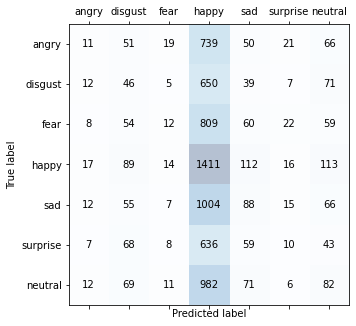

In [96]:
# Show only the best one 
i = 2
confmat = confusion_matrix(y_true=brisk_actuals[i], y_pred=brisk_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [98]:
showPerformance(brisk_predictions, brisk_actuals)

data/sift/sift_bof_100.csv
Precision: 0.133
Recall: 0.141
F1: 0.118
Accuracy: 0.187
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.08      0.10       957
     disgust       0.05      0.00      0.01       830
        fear       0.11      0.04      0.06      1024
       happy       0.22      0.56      0.32      1773
         sad       0.16      0.15      0.15      1247
    surprise       0.08      0.03      0.05       831
     neutral       0.15      0.13      0.14      1233

    accuracy                           0.19      7895
   macro avg       0.13      0.14      0.12      7895
weighted avg       0.15      0.19      0.14      7895

data/sift/sift_bof_500.csv
Precision: 0.161
Recall: 0.153
F1: 0.140
Accuracy: 0.190
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.07      0.09       957
     disgust       0.15      0.12      0.13       830
        fear       0.14   

# SVM with AKAZE

In [32]:
csv_list = ['data/akaze/akaze_bof_100.csv', 'data/akaze/akaze_bof_500.csv', 'data/akaze/akaze_bof_1000.csv', 
            'data/akaze/akaze_pca_bof_100.csv', 'data/akaze/akaze_pca_bof_500.csv', 'data/akaze/akaze_pca_bof_1000.csv']

In [33]:
akaze_predictions = []
akaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    akaze_predictions.append(pred)
    akaze_actuals.append(act)

data/akaze/akaze_bof_100.csv
(31332, 99)
(31332,)
(7862, 99)
(7862,)
Test Accuracy: 0.191
data/akaze/akaze_bof_500.csv
(31332, 499)
(31332,)
(7862, 499)
(7862,)
Test Accuracy: 0.189
data/akaze/akaze_bof_1000.csv
(31332, 999)
(31332,)
(7862, 999)
(7862,)
Test Accuracy: 0.197
data/akaze/akaze_pca_bof_100.csv
(25314, 99)
(25314,)
(6606, 99)
(6606,)
Test Accuracy: 0.215
data/akaze/akaze_pca_bof_500.csv
(25314, 499)
(25314,)
(6606, 499)
(6606,)
Test Accuracy: 0.214
data/akaze/akaze_pca_bof_1000.csv
(25314, 999)
(25314,)
(6606, 999)
(6606,)
Test Accuracy: 0.218


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_8072\1833250243.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


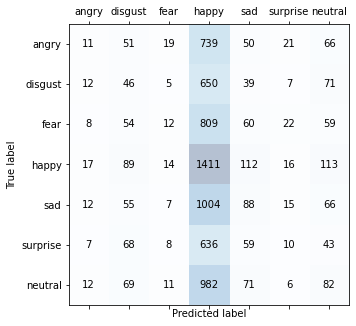

In [96]:
# Show only the best one 
i = 3
confmat = confusion_matrix(y_true=akaze_actuals[i], y_pred=akaze_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [98]:
showPerformance(akaze_predictions, akaze_actuals)

data/sift/sift_bof_100.csv
Precision: 0.133
Recall: 0.141
F1: 0.118
Accuracy: 0.187
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.08      0.10       957
     disgust       0.05      0.00      0.01       830
        fear       0.11      0.04      0.06      1024
       happy       0.22      0.56      0.32      1773
         sad       0.16      0.15      0.15      1247
    surprise       0.08      0.03      0.05       831
     neutral       0.15      0.13      0.14      1233

    accuracy                           0.19      7895
   macro avg       0.13      0.14      0.12      7895
weighted avg       0.15      0.19      0.14      7895

data/sift/sift_bof_500.csv
Precision: 0.161
Recall: 0.153
F1: 0.140
Accuracy: 0.190
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.07      0.09       957
     disgust       0.15      0.12      0.13       830
        fear       0.14   

# SVM with HoG

In [4]:
csv_list = ['data/hog/hog_data2.csv', 'data/hog/hog_scaled2.csv']

In [6]:
hog_predictions = []
hog_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 3)
    hog_predictions.append(pred)
    hog_actuals.append(act)

data/hog/hog_data2.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.405
data/hog/hog_scaled2.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.500
Test Accuracy: 0.458


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11412\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11412\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


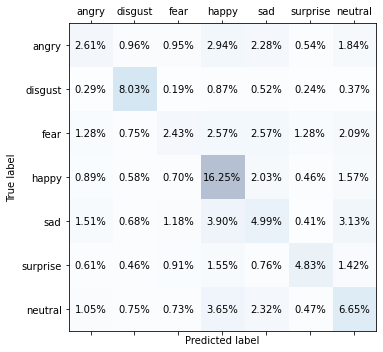

In [10]:
# Show only the best one 
i = 1
confmat = confusion_matrix(y_true=hog_actuals[i], y_pred=hog_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [11]:
showPerformance(hog_predictions, hog_actuals)

data/hog/hog_data2.csv
Precision: 0.816
Recall: 0.374
F1: 0.353
Accuracy: 0.405
Classification reports
              precision    recall  f1-score   support

       angry       0.90      0.08      0.15       957
     disgust       1.00      1.00      1.00       830
        fear       0.88      0.12      0.21      1024
       happy       0.28      1.00      0.43      1774
         sad       0.86      0.06      0.11      1247
    surprise       0.98      0.29      0.45       831
     neutral       0.82      0.06      0.12      1233

    accuracy                           0.40      7896
   macro avg       0.82      0.37      0.35      7896
weighted avg       0.76      0.40      0.33      7896

data/hog/hog_scaled2.csv
Precision: 0.447
Recall: 0.441
F1: 0.435
Accuracy: 0.458
Classification reports
              precision    recall  f1-score   support

       angry       0.32      0.22      0.26       957
     disgust       0.66      0.76      0.71       830
        fear       0.34      0.1

# Benchmark

## Find out best parameter for benchmark

It is done in KNN notebook and most_frequent strategy seems the best.

## Check with Best PCA data

In [27]:
df = pd.read_csv('data/pca/fer_pca_std.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.7174040838712432 -0.7702660905290193 -0.513...
1,train,3,0.7212745110957715 0.8709909412648307 -0.05813...
2,train,3,-1.1415807452074815 -0.9530090924132242 0.6111...
3,train,3,-1.2521535857006059 0.13698174383357514 0.5316...
4,train,3,0.294048049351381 0.832202280005905 0.10490519...


In [28]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [29]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [30]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [31]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with Best LDA data

In [32]:
df = pd.read_csv('data/lda/fer_lda.csv')
df.head()

,usage,emotion,lda
0,train,3,0.7152285057766292 -0.31546082598153313 -1.197...
1,train,3,0.3994195348114538 0.08081985090189124 0.14165...
2,train,3,-0.3665155978973077 -1.178830004566658 0.08523...
3,train,3,-0.10176839734754776 -0.3560634180815157 -1.42...
4,train,3,0.049854946862418495 -0.9834076711949291 -0.75...


In [34]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 4)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 4)
test_target = list(df_test.emotion)

In [35]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [36]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [38]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with Best BoF data

In [41]:
df = pd.read_csv('data/akaze/akaze_pca_bof_1000.csv')
df.head()

,usage,emotion,histogram
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [43]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 2)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 2)
test_target = list(df_test.emotion)

In [44]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [45]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.22220905427826498

In [46]:
dummy.score(X_test, y_test)

0.21964880411746895

## Check with Best HoG data

In [47]:
df = pd.read_csv('data/hog/hog_data.csv')
df.head()

,usage,emotion,hog
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [48]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 3)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 3)
test_target = list(df_test.emotion)

In [49]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [50]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [51]:
dummy.score(X_test, y_test)

0.2246707193515704

# Get better result

## Hyper parameter tuning

Use PCA Standardization data

In [25]:
df = pd.read_csv('data/pca/fer_pca_std.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.7174040838712432 -0.7702660905290193 -0.513...
1,train,3,0.7212745110957715 0.8709909412648307 -0.05813...
2,train,3,-1.1415807452074815 -0.9530090924132242 0.6111...
3,train,3,-1.2521535857006059 0.13698174383357514 0.5316...
4,train,3,0.294048049351381 0.832202280005905 0.10490519...


In [26]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [27]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [ ]:
param_gamma = ['auto', 'scale']
param_c = [1, 5, 10, 100]
param_grid = [{'C': param_c,
               'kernel': ['linear']},
              {'C': param_c,
               'gamma': param_gamma, 
               'kernel': ['rbf']},
              {'C': param_c,
               'gamma': param_gamma,
               'kernel': ['poly']}]

svm = SVC(random_state=1, decision_function_shape='ovo')

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [ ]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

## K-fold cross-validation

In [ ]:
svm = SVC(C=5, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
scores = cross_val_score(estimator=svm,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Visualizing learning curves and validation curves

In [ ]:
svm = SVC(C=5, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=svm,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

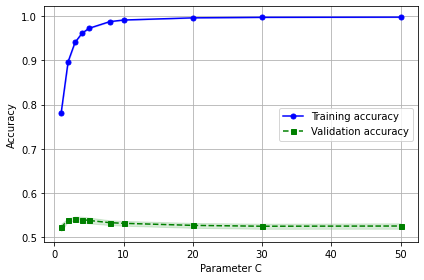

In [28]:
svm = SVC(random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
param_range = [1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 10.0, 20.0, 30.0, 50.0]

train_scores, test_scores = validation_curve(
                estimator=svm, 
                X=X_train, 
                y=y_train, 
                param_name='C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
# plt.xscale('log')
plt.legend(loc='center right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [18]:
svm = SVC(C=3, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
print('Test Accuracy: %.3f' % svm.score(X_test, y_test))

Train Accuracy: 0.939
Test Accuracy: 0.558


C:\Users\CREATE\AppData\Local\Temp\ipykernel_7100\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_7100\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


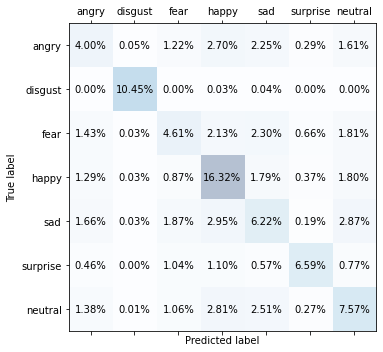

In [21]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=targets)
show_confusion_matrix(confmat)

In [22]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

Precision: 0.577
Recall: 0.559
F1: 0.564
Accuracy: 0.558


In [24]:
print(classification_report(y_test, y_pred, target_names=list(target_labels)))

              precision    recall  f1-score   support

       angry       0.39      0.33      0.36       957
     disgust       0.99      0.99      0.99       830
        fear       0.43      0.36      0.39      1024
       happy       0.58      0.73      0.65      1774
         sad       0.40      0.39      0.40      1247
    surprise       0.79      0.63      0.70       831
     neutral       0.46      0.48      0.47      1233

    accuracy                           0.56      7896
   macro avg       0.58      0.56      0.56      7896
weighted avg       0.56      0.56      0.55      7896

